In [1]:
'''
The code for generating the supplementary and extended data figures.

Siyuan Mei (mei@bio.lmu.de)
2026-01-03
'''

%load_ext autoreload
%autoreload 2
import pickle 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import combine_pvalues
from tqdm import tqdm

from HD_utils.defaults import *
from HD_utils.HD_functions import subtract_preferred_HD_activity
from plot05 import *

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = ['Arial']

# Math text in Arial (uses sans-serif STIX fallback)
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['mathtext.it'] = 'Arial:italic'
plt.rcParams['mathtext.bf'] = 'Arial:bold'

axtitle_size = 15.4 * 0.9
figtitle_size = 18 * 0.9
plt.rcParams['axes.titlesize'] = axtitle_size      # Axes title (ax.set_title) -> 12 in krita
plt.rcParams['figure.titlesize'] = figtitle_size    # Figure title (fig.suptitle)  -> 14 in krita

label_size = 12.9 * 0.9
plt.rcParams['axes.labelsize'] = label_size      # X and Y labels -> 10 in krita
plt.rcParams['figure.labelsize'] = label_size

tick_size = 11.6 * 0.9
plt.rcParams['xtick.labelsize'] = tick_size     # X tick labels -> 9 in krita
plt.rcParams['ytick.labelsize'] = tick_size     # Y tick labels
plt.rcParams.update({'font.size': tick_size})

# Ext1. Activity Patterns

In [ ]:
# Load data
data_df = pd.read_pickle(FISH_RESULT_PATH / "ruben_data_timeseries_cos.pkl")
stat_df = pd.read_pickle(FISH_RESULT_PATH / "ruben_lm_result_cos.pkl")

data_df = subtract_preferred_HD_activity(data_df, stat_df)

# Calculate required variables
vlimit = np.mean(np.abs(np.quantile(data_df.angVel, [1/(NBINS+2), 1-1/(NBINS+2)])))
angVel_bin_edge = np.linspace(-vlimit, vlimit, NBINS+1)
data_df['angVel_bin'] = np.digitize(data_df.angVel, angVel_bin_edge)

sum_df = data_df.groupby(['fish', 'cell', 'angVel_bin']).agg({'activity_subtract': 'mean'}).reset_index()
sum_df = sum_df.merge(stat_df[['fish', 'cell', 'ring', 'speed_modu']], on=['fish', 'cell'], how='left')

sum_df.ring = sum_df.ring.cat.rename_categories({'center': 'Symmetric', 'left': 'CW', 'right': 'CCW'})

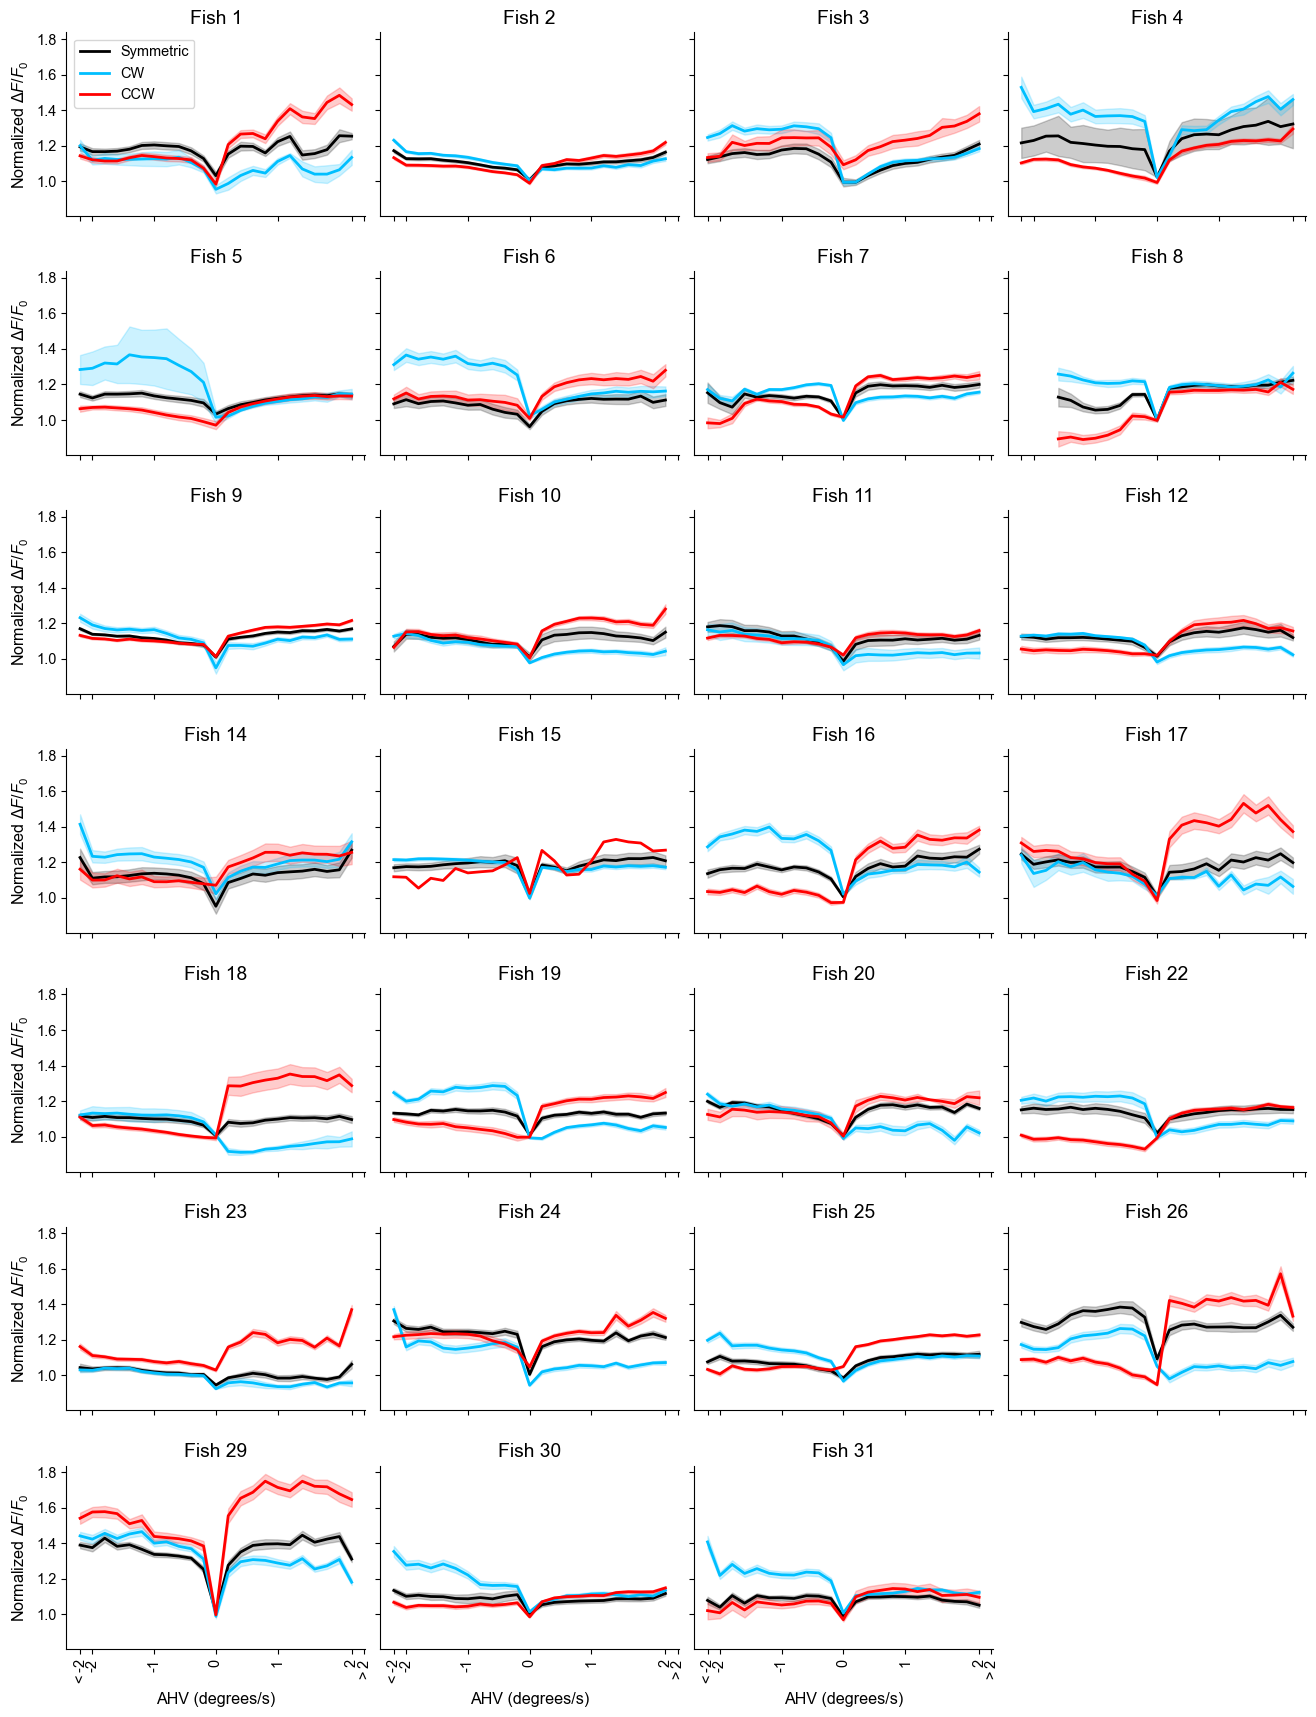

In [ ]:
# Create figure
nplots = FISH_NUM
ncols = 4
nrows = int(np.ceil(nplots/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols,3*nrows), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.3, wspace=0.05)

for counti, fishi in enumerate(FISH_IDS):
    ax = axes.flatten()[counti]
    
    df_fish = sum_df[sum_df.fish == fishi].copy()
    baseline_acv = df_fish.loc[df_fish.angVel_bin == (NBINS+1)//2, 'activity_subtract'].mean()
    df_fish['activity_norm'] = df_fish["activity_subtract"] / baseline_acv
    
    iflegend = True if counti == 0 else False
    plot_acv_on_AHV(df_fish, NBINS, ax, iflegend, angVel_bin_edge)
    ax.set_title(f'Fish {fishi+1}')

axes.flatten()[-1].remove()

fig.savefig(FIGURE_PATH / 'ext-3f1.png', dpi=600, bbox_inches='tight')
plt.show()

# Ext2. Cell Location

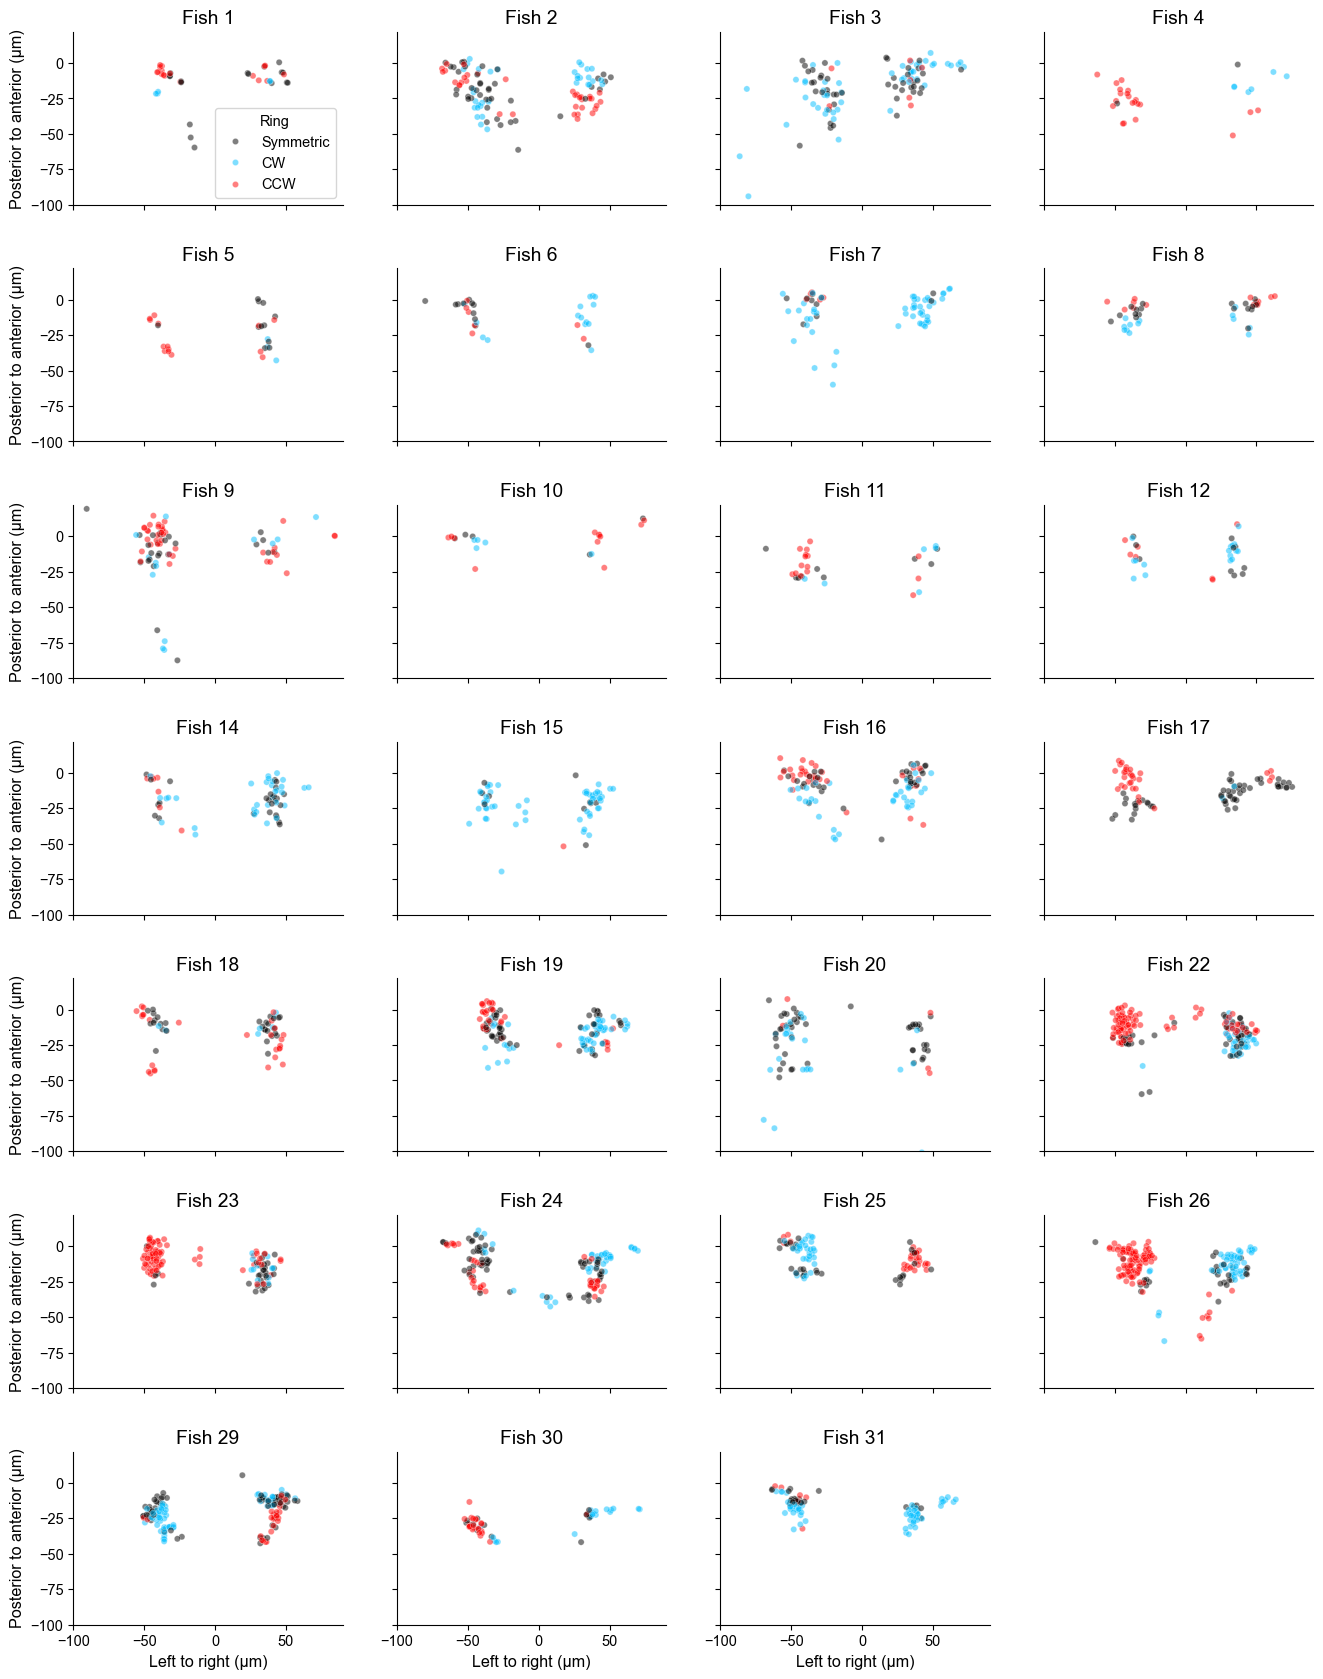

In [ ]:
stat_df = pd.read_pickle(FISH_RESULT_PATH / "ruben_lm_result_cos.pkl")
stat_df.ring = stat_df.ring.cat.rename_categories({'center': 'Symmetric', 'left': 'CW', 'right': 'CCW'})

nplots = FISH_NUM
ncols = 4
nrows = int(np.ceil(nplots/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols,3*nrows), sharex=True, sharey=True)

for i, fishi in enumerate(FISH_IDS):
    ax = axes.flatten()[i]
    iflegend = True if i == 0 else False
    
    stat_df_fish = stat_df[stat_df.fish == fishi]
    g = plot_cell_location(ax, stat_df_fish, iflegend=iflegend)
    ax.set_title(f'Fish {fishi+1}')

axes.flatten()[-1].remove()

fig.savefig(FIGURE_PATH / 'ext-3j1.png', dpi=600, bbox_inches='tight')
plt.show()

# Ext3a. HD Distribution (Shifter Rings)

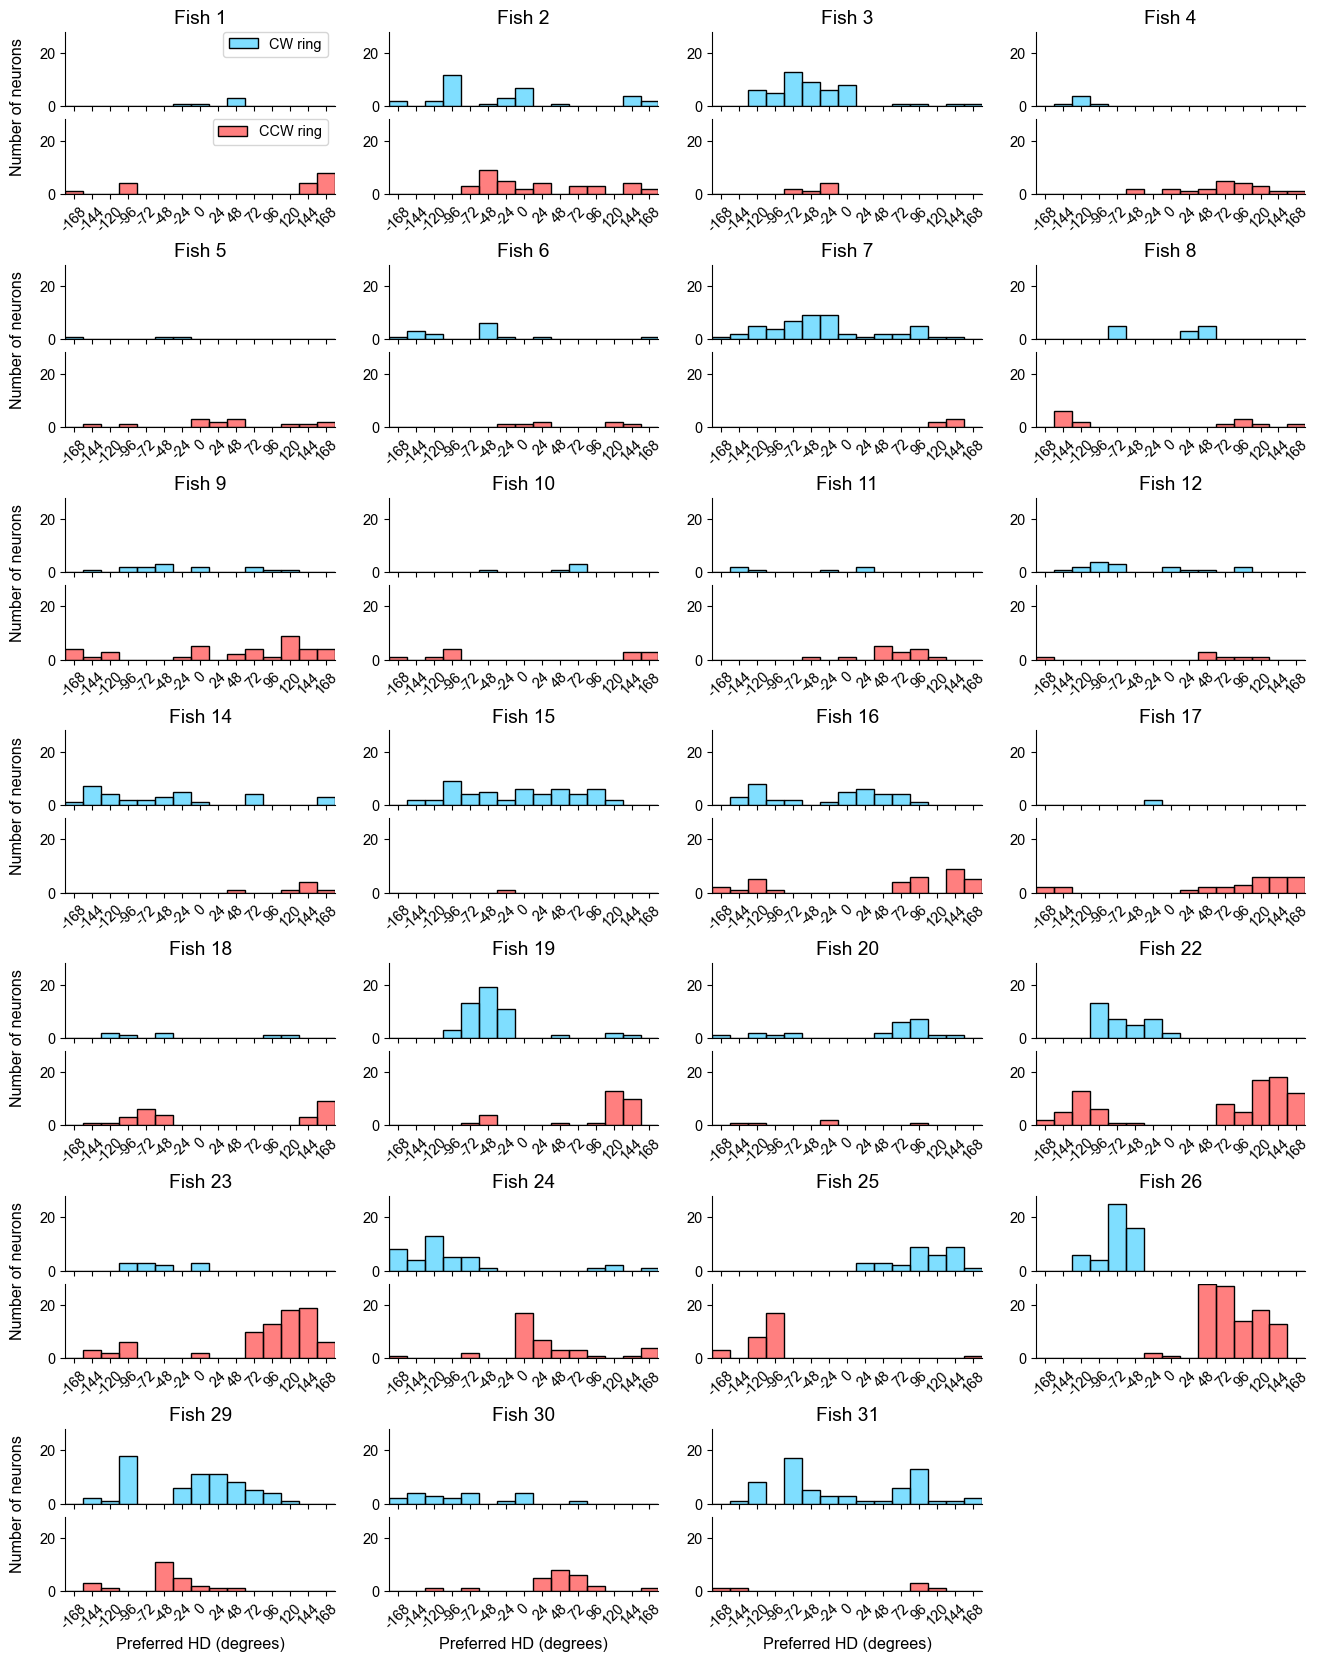

In [ ]:
stat_df = pd.read_pickle(FISH_RESULT_PATH / "ruben_lm_result_cos.pkl")
stat_df.ring = stat_df.ring.cat.rename_categories({'center': 'Symmetric', 'left': 'Left', 'right': 'Right'})

# Set bin width
bin_num = 15

# Create figure
nplots = FISH_NUM
ncols = 4
nrows = int(np.ceil(nplots/ncols))
fig = plt.figure(figsize=(4*ncols,3*nrows))

# Define heights - normal rows + extra space after every 2 rows
row_heights = [1, 1, 0.6] * nrows 
gs = gridspec.GridSpec(3*nrows,ncols,height_ratios=row_heights, figure=fig)

# Individual fish
for i, fishi in enumerate(FISH_IDS):
    iflegend = True if i == 0 else False
    stat_df_fish = stat_df[stat_df.fish == fishi]
    
    
    ax1 = fig.add_subplot(gs[(i)//ncols*3, (i)%ncols])
    plot_left_or_right_ring(ax1, stat_df_fish, 'Left', bin_num, legend=iflegend)
    
    ax1.set_title(f'Fish {fishi+1}')
    if ((i)%ncols) == 0:
        ax1.set_ylabel('Number of neurons', y=0, labelpad=10)
        ax1.yaxis.set_label_coords(-0.15, 0)
    set_radian_ticks(ax1, bin_num, ticklabels=False)
    ax1.set_xlabel('')
    
    
    ax2 = fig.add_subplot(gs[(i)//ncols*3+1, (i)%ncols])
    plot_left_or_right_ring(ax2, stat_df_fish, 'Right', bin_num, legend=iflegend)
    
    set_radian_ticks(ax2, bin_num)
    if ((i)//ncols) == nrows-1:
        ax2.set_xlabel('Preferred HD (degrees)')
    else:
        ax2.set_xlabel('')

# Formatting figures
all_axes = fig.get_axes()
for i, ax in enumerate(all_axes):
    remove_top_right_spines(ax)

fig.savefig(FIGURE_PATH / 'ext-3m2.png', dpi=600, bbox_inches='tight')
plt.show()

# Ext3b. HD Distribution (Symmetric Ring & All)

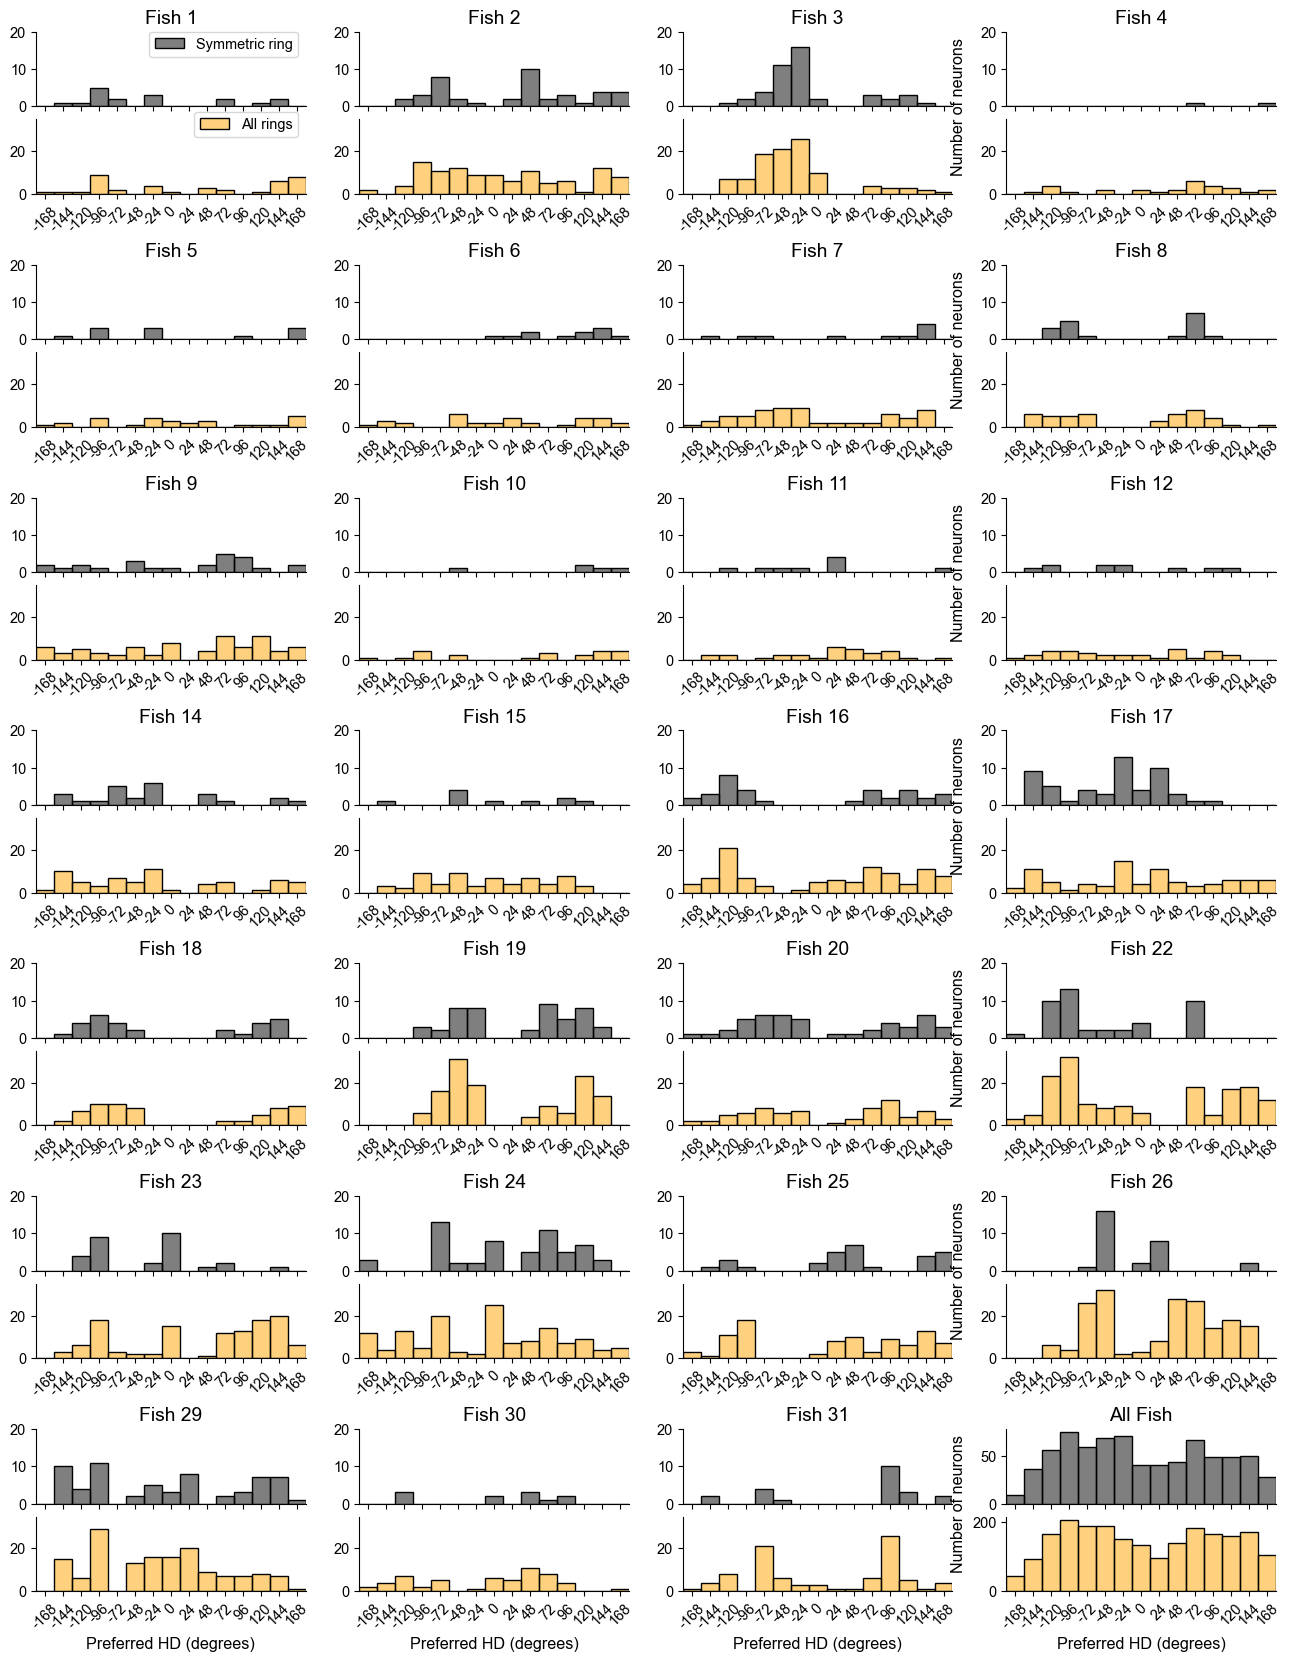

In [ ]:
stat_df.ring = stat_df.ring.cat.rename_categories({'center': 'Symmetric', 'left': 'Left', 'right': 'Right'})

# Set bin width
bin_num = 15

# Create figure
nplots = FISH_NUM+1
ncols = 4
nrows = int(np.ceil(nplots/ncols))
fig = plt.figure(figsize=(4*ncols,3*nrows))

# Define heights - normal rows + extra space after every 2 rows
row_heights = [1, 1, 0.6] * nrows 
gs = gridspec.GridSpec(3*nrows,ncols,height_ratios=row_heights, figure=fig)

# Individual fish
for i, fishi in enumerate(FISH_IDS):
    stat_df_fish = stat_df[stat_df.fish == fishi]
    
    ax1 = fig.add_subplot(gs[(i)//ncols*3, (i)%ncols])
    plot_symmetric_ring(ax1, stat_df_fish, bin_num, legend=(i==0))
    
    ax1.set_title(f'Fish {fishi+1}')
    if ((i+1)%ncols) == 0:
        ax1.set_ylabel('Number of neurons', y=0, labelpad=10)
        ax1.yaxis.set_label_coords(-0.15, 0)
    ax1.set_ylim(0,20)
    set_radian_ticks(ax1, bin_num, ticklabels=False)
    ax1.set_xlabel('')
    
    
    ax2 = fig.add_subplot(gs[(i)//ncols*3+1, (i)%ncols])
    plot_all_rings(ax2, stat_df_fish, bin_num, legend=(i==0))
    
    set_radian_ticks(ax2, bin_num)
    if ((i)//ncols) == nrows-1:
        ax2.set_xlabel('Preferred HD (degrees)')
    else:
        ax2.set_xlabel('')
    ax2.set_ylim(0,35)
    
# All fish
ax1 = fig.add_subplot(gs[nrows*3-3, ncols-1])
plot_symmetric_ring(ax1, stat_df, bin_num, legend=False)

ax1.set_title('All Fish')
ax1.set_ylabel('Number of neurons', y=0)
ax1.yaxis.set_label_coords(-0.15, 0)
set_radian_ticks(ax1, bin_num, ticklabels=False)
ax1.set_xlabel('')


ax2 = fig.add_subplot(gs[nrows*3-2, ncols-1])
plot_all_rings(ax2, stat_df, bin_num, legend=False)

set_radian_ticks(ax2, bin_num)
ax2.set_xlabel('Preferred HD (degrees)')

# Formatting figures
all_axes = fig.get_axes()
for i, ax in enumerate(all_axes):
    remove_top_right_spines(ax)

fig.savefig(FIGURE_PATH / 'ext-3m1.png', dpi=600, bbox_inches='tight')
plt.show()

# Ext3. Nonuniformity Test

In [ ]:
from pingouin import circ_rayleigh
stat_df = pd.read_pickle(FISH_RESULT_PATH / "ruben_lm_result_cos.pkl")
stat = np.zeros((4, FISH_NUM))
pvals = np.zeros((4, FISH_NUM))
nums = np.zeros((4, FISH_NUM), dtype=int)
for fishi, fish in enumerate(FISH_IDS):
    stat_df_fish = stat_df[stat_df.fish == fish]
    stat[0, fishi], pvals[0, fishi] = circ_rayleigh(stat_df_fish.preferred_angle)
    nums[0, fishi] = len(stat_df_fish)
    for ringi, ring in enumerate(['center', 'left', 'right']):
        stat[ringi+1, fishi], pvals[ringi+1, fishi] = circ_rayleigh(stat_df_fish[stat_df_fish.ring == ring].preferred_angle)
        nums[ringi+1, fishi] = len(stat_df_fish[stat_df_fish.ring == ring])

labels = ['All', 'Symmetric', 'CW', 'CCW']
for i in range(4):
    res = combine_pvalues(pvals[i, :], method='fisher')
    res2 = combine_pvalues(pvals[i, :], method='pearson')
    print(f"--- {labels[i]} ---")
    print(f"Fisher method: {res.statistic:.1f}, p-value: {res.pvalue}")
    print(f"Pearson method: {res2.statistic:.1f}, p-value: {res2.pvalue}")


labels = ['All rings', 'Symmetric ring', 'CW ring', 'CCW ring']

dfs = []
dfs.append(pd.DataFrame({'Fish ID': FISH_IDS}))
for i in range(4):
    df = pd.DataFrame({
        labels[i] + ' stat': stat[i, :],
        labels[i] + ' pval': pvals[i, :],
        labels[i] + ' n': nums[i, :],})
    dfs.append(df)
df = pd.concat(dfs, axis=1)

pd.set_option('display.float_format', '{:.3e}'.format)
df.to_csv(TABLE_PATH / "Supplementary table 4. Non-uniformity test.csv", index=False)
ccw_sig_num = np.sum(pvals[3, :]*FISH_NUM*2 < 0.05)
cw_sig_num = np.sum(pvals[2, :]*FISH_NUM*2 < 0.05)
print(f"SIG NUM, CCW: {ccw_sig_num}, CW: {cw_sig_num}")

--- All ---
Fisher method: 307.7, p-value: 3.3933473418212226e-37
Pearson method: -23.9, p-value: 0.00012522011640512154
--- Symmetric ---
Fisher method: 212.3, p-value: 1.2252250836962375e-20
Pearson method: -18.5, p-value: 1.5761319067235537e-06
--- CW ---
Fisher method: 597.7, p-value: 1.0141707084283382e-92
Pearson method: -6.9, p-value: 1.2097784848274122e-15
--- CCW ---
Fisher method: 710.5, p-value: 2.9131656698985905e-115
Pearson method: -5.9, p-value: 3.0318689760901265e-17
SIG NUM, CCW: 15, CW: 10


# Supplementary Figure: Non HD Cells

## Prepare Data: Exclude Optical Tectum & Rhomb. 2

In [ ]:
from lotr import LotrExperiment

results_list = []
for fishi in FISH_IDS:
    exp = LotrExperiment(DATA_FOLDERS[fishi])
    
    hdn_ids = exp.hdn_indexes

    coords = np.delete(exp.morphed_coords_um[:, :], hdn_ids, axis=0)
    coords[:, 1] = coords[:, 1] + 16  # arbitrary centering
    
    cell_num = coords.shape[0]
    
    results_list.append(
        pd.DataFrame(
            dict(
                fish=np.repeat(fishi,cell_num),
                cell=np.arange(cell_num),
                dv_pos=coords[:, 0],
                lr_pos=coords[:, 1],
                ap_pos=coords[:, 2],
            )
        )
    )
    
pos_df = pd.concat(results_list, axis=0).reset_index(drop=True)
pos_df.to_pickle(FISH_RESULT_PATH / 'ruben_cell_position_for_anatomical_selection.pkl')

In [ ]:
# Load and merge df
pos_df = pd.read_pickle(FISH_RESULT_PATH / 'ruben_cell_position_for_anatomical_selection.pkl')
stat_noHD_df = pd.read_pickle(FISH_RESULT_PATH / "ruben_lm_result_noHD.pkl")
stat_noHD_df = pd.merge(stat_noHD_df, pos_df, on=['fish', 'cell'], how='left')

# Select cells in aHB
stat_noHD_df["ahb"] = (
    np.sqrt((stat_noHD_df["lr_pos"] - 15) ** 2 + (stat_noHD_df["ap_pos"] + 165) ** 2) < 180
) & (np.sqrt((stat_noHD_df["lr_pos"] - 15) ** 2 + (stat_noHD_df["ap_pos"] + 250) ** 2) > 194)
stat_noHD_ahb = stat_noHD_df[stat_noHD_df.ahb].copy()
stat_noHD_ahb.ring = stat_noHD_ahb.ring.replace({'center': 'Symmetric', 'left': 'Left', 'right': 'Right'})
stat_noHD_ahb.loc[:,'anatomical_loc'] = stat_noHD_ahb.anatomical_loc.str.capitalize()

stat_HD = pd.read_pickle(FISH_RESULT_PATH / "ruben_lm_result_cos.pkl")
dist2HD = []
HD_cell_coords = stat_HD[['x', 'y', 'z']].values
for rowi in range(len(stat_noHD_ahb)):
    non_HD_cell_coord = (stat_noHD_ahb.iloc[rowi][['x', 'y', 'z']].values).astype(np.float64)
    dists = np.linalg.norm(HD_cell_coords - non_HD_cell_coord, axis=1)
    dist2HD.append(np.min(dists))
stat_noHD_ahb['dist2HD'] = dist2HD
stat_noHD_ahb.to_pickle(FISH_RESULT_PATH / "ruben_lm_result_noHD_aHB.pkl")

## Sup1. Proportion of the Same AHS Modulation

In [ ]:
stat_HD = pd.read_pickle(FISH_RESULT_PATH / "ruben_lm_result_cos.pkl")
stat_HD = stat_HD.replace({'center': 'Symmetric', 'left': 'Left', 'right': 'Right'})
# select the nearest noHD cells
dist_ranges = np.array([0,10,20,30,40,50,60,70,80])
dist_centers = dist_ranges[:-1] + np.diff(dist_ranges)/2
dist_num = len(dist_centers)

fish_list = []
cell_list = []
ring_list = []
dist_list = []
prop_list = []

for fishi in tqdm(FISH_IDS):
    df_noHD_fish = stat_noHD_ahb.loc[stat_noHD_ahb['fish'] == fishi]
    coor_noHD_fish = df_noHD_fish[['x', 'y', 'z']].values
    
    df_HD_fish = stat_HD.loc[stat_HD['fish'] == fishi]
    cell_ids = df_HD_fish['cell'].unique()
    
    for cell_count, celli in (enumerate(cell_ids)):
        HD_ring = df_HD_fish.loc[df_HD_fish['cell'] == celli, ['ring']].values[0,0]
        coor_HD_cell = df_HD_fish.loc[df_HD_fish['cell'] == celli, ['x', 'y', 'z']].values
        dist = np.linalg.norm(coor_noHD_fish - coor_HD_cell, axis=1)
        
        for bini in range(dist_num):
            minv = dist_ranges[bini]
            maxv = dist_ranges[bini+1]
            inrange_ids = np.where((dist>minv) & (dist<=maxv))[0]
            prop = np.mean(df_noHD_fish.iloc[inrange_ids].ring == HD_ring)
            
            fish_list.append(fishi)
            cell_list.append(celli)
            ring_list.append(HD_ring)
            dist_list.append(dist_centers[bini])
            prop_list.append(prop)
            
stat_ring_on_dist = pd.DataFrame({'fish': fish_list, 'cell': cell_list, 'ring': ring_list, 'dist': dist_list, 'prop': prop_list})
stat_ring_on_dist.to_pickle(FISH_RESULT_PATH / "stat_ring_on_dist_aHB.pkl")

100%|██████████| 27/27 [00:05<00:00,  4.89it/s]


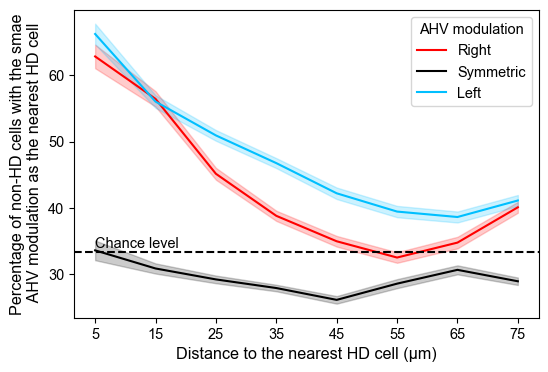

In [ ]:
stat_ring_on_dist = pd.read_pickle(FISH_RESULT_PATH / "stat_ring_on_dist_aHB.pkl")
stat_ring_on_dist.ring = stat_ring_on_dist.ring.replace({'center': 'Symmetric', 'left': 'CW', 'right': 'CCW'})

fig, ax = plt.subplots(figsize=(6, 4))
stat_ring_on_dist.prop *= 100
sns.lineplot(stat_ring_on_dist, x='dist', y='prop', hue='ring', palette=COLORMAP_S, ax=ax, errorbar='se')

legend = ax.legend(title='AHV modulation', loc='upper right')
ax.set_ylabel('Percentage of non-HD cells with the smae\n AHV modulation as the nearest HD cell')
ax.set_xlabel('Distance to the nearest HD cell (µm)')
dist_ranges = np.array([0,10,20,30,40,50,60,70,80])
dist_centers = dist_ranges[:-1] + np.diff(dist_ranges)//2
ax.set_xticks(dist_centers)

ax.axhline(33.3, color='k', linestyle='dashed', label='Chance level')
ax.text(5, 34, 'Chance level')

fig.savefig(FIGURE_PATH / 'sup1.png', dpi=600, bbox_inches='tight')
plt.show()

## Sup2. Select Non-HD Cells based on Distance and Plot thier Properties

In [ ]:
# Calculate and store acv on AHV
from HD_utils.HD_functions import select_cell, add_angvel__ring_to_acv_df, cal_mean_acv_per_bin

data_noHD_acv = pd.read_pickle(FISH_RESULT_PATH / "data_ruben_noHD_acv.pkl")
data_noHD_vel = pd.read_pickle(FISH_RESULT_PATH / "data_ruben_noHD_vel.pkl")

# Calculate angVel_bin
vlimit = np.mean(np.abs(np.quantile(data_noHD_vel.angVel, [1/(NBINS+2), 1-1/(NBINS+2)])))
angVel_bin_edge = np.linspace(-vlimit, vlimit, NBINS+1)
data_noHD_vel['angVel_bin'] = np.digitize(data_noHD_vel.angVel, angVel_bin_edge)

for i, athreshold in enumerate(THRESHOLDS):
    
    data_noHD_acv2 = select_cell(stat_noHD_ahb, athreshold[0], athreshold[1], data_noHD_acv)
    data_noHD = add_angvel__ring_to_acv_df(data_noHD_acv2, stat_noHD_ahb, data_noHD_vel)
    data_sum = cal_mean_acv_per_bin(data_noHD, NBINS)
    data_sum.to_pickle(FISH_RESULT_PATH / f"data_ruben_noHD_ahb_acv_on_AHV_thres{i}.pkl")

100%|██████████| 17/17 [00:00<00:00, 20.20it/s]


c:\ProgramData\miniforge3\envs\HD\lib\site-packages\pingouin\parametric.py:336: UserWarning: registration of accessor <class 'pandas_flavor.register.register_dataframe_method.<locals>.inner.<locals>.AccessorMethod'> under name 'rm_anova' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  def rm_anova(
c:\ProgramData\miniforge3\envs\HD\lib\site-packages\pingouin\parametric.py:810: UserWarning: registration of accessor <class 'pandas_flavor.register.register_dataframe_method.<locals>.inner.<locals>.AccessorMethod'> under name 'anova' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  def anova(data=None, dv=None, between=None, ss_type=2, detailed=False, effsize="np2"):
c:\ProgramData\miniforge3\envs\HD\lib\site-packages\pingouin\parametric.py:1220: UserWarning: registration of accessor <class 'pandas_flavor.register.register_dataframe_method.<locals>.inner.<locals>.AccessorMeth


 (0, inf)
left_right: t(27) =-4.327, p = 0.000
posterior_anterior: t(27) =-0.255, p = 0.801
ventral_dorsal: t(27) =-0.072, p = 0.943
L ring on R side, stat: 3.400e+01, p: 5.488e-05
R ring on L side, stat: 4.100e+01, p: 1.428e-04

 (0, 5)
left_right: t(27) =-0.870, p = 0.392
posterior_anterior: t(27) =-3.384, p = 0.002
ventral_dorsal: t(27) = 0.225, p = 0.823
L ring on R side, stat: 1.710e+02, p: 6.790e-01
R ring on L side, stat: 1.780e+02, p: 8.040e-01

 (5, 10)
left_right: t(27) =-5.261, p = 0.000
posterior_anterior: t(27) =-2.445, p = 0.022
ventral_dorsal: t(27) = 0.322, p = 0.750
L ring on R side, stat: 1.100e+01, p: 8.196e-07
R ring on L side, stat: 2.900e+01, p: 2.587e-05

 (10, 20)
left_right: t(27) =-7.411, p = 0.000
posterior_anterior: t(27) = 0.334, p = 0.741
ventral_dorsal: t(27) =-1.229, p = 0.230
L ring on R side, stat: 3.000e+00, p: 1.181e-05
R ring on L side, stat: 5.000e+00, p: 1.490e-07

 (20, 40)


c:\ProgramData\miniforge3\envs\HD\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


left_right: t(16) =-0.392, p = 0.701
posterior_anterior: t(16) = 1.491, p = 0.157
ventral_dorsal: t(16) =-0.207, p = 0.839
L ring on R side, stat: 8.900e+01, p: 5.503e-01
R ring on L side, stat: 6.450e+01, p: 4.411e-02

 (40, inf)


c:\ProgramData\miniforge3\envs\HD\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


left_right: t(7) = 1.664, p = 0.147
posterior_anterior: t(7) =-0.114, p = 0.913
ventral_dorsal: t(7) = 1.471, p = 0.192
L ring on R side, stat: 0.000e+00, p: 1.088e-01
R ring on L side, stat: 0.000e+00, p: 6.789e-02


c:\ProgramData\miniforge3\envs\HD\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\ProgramData\miniforge3\envs\HD\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


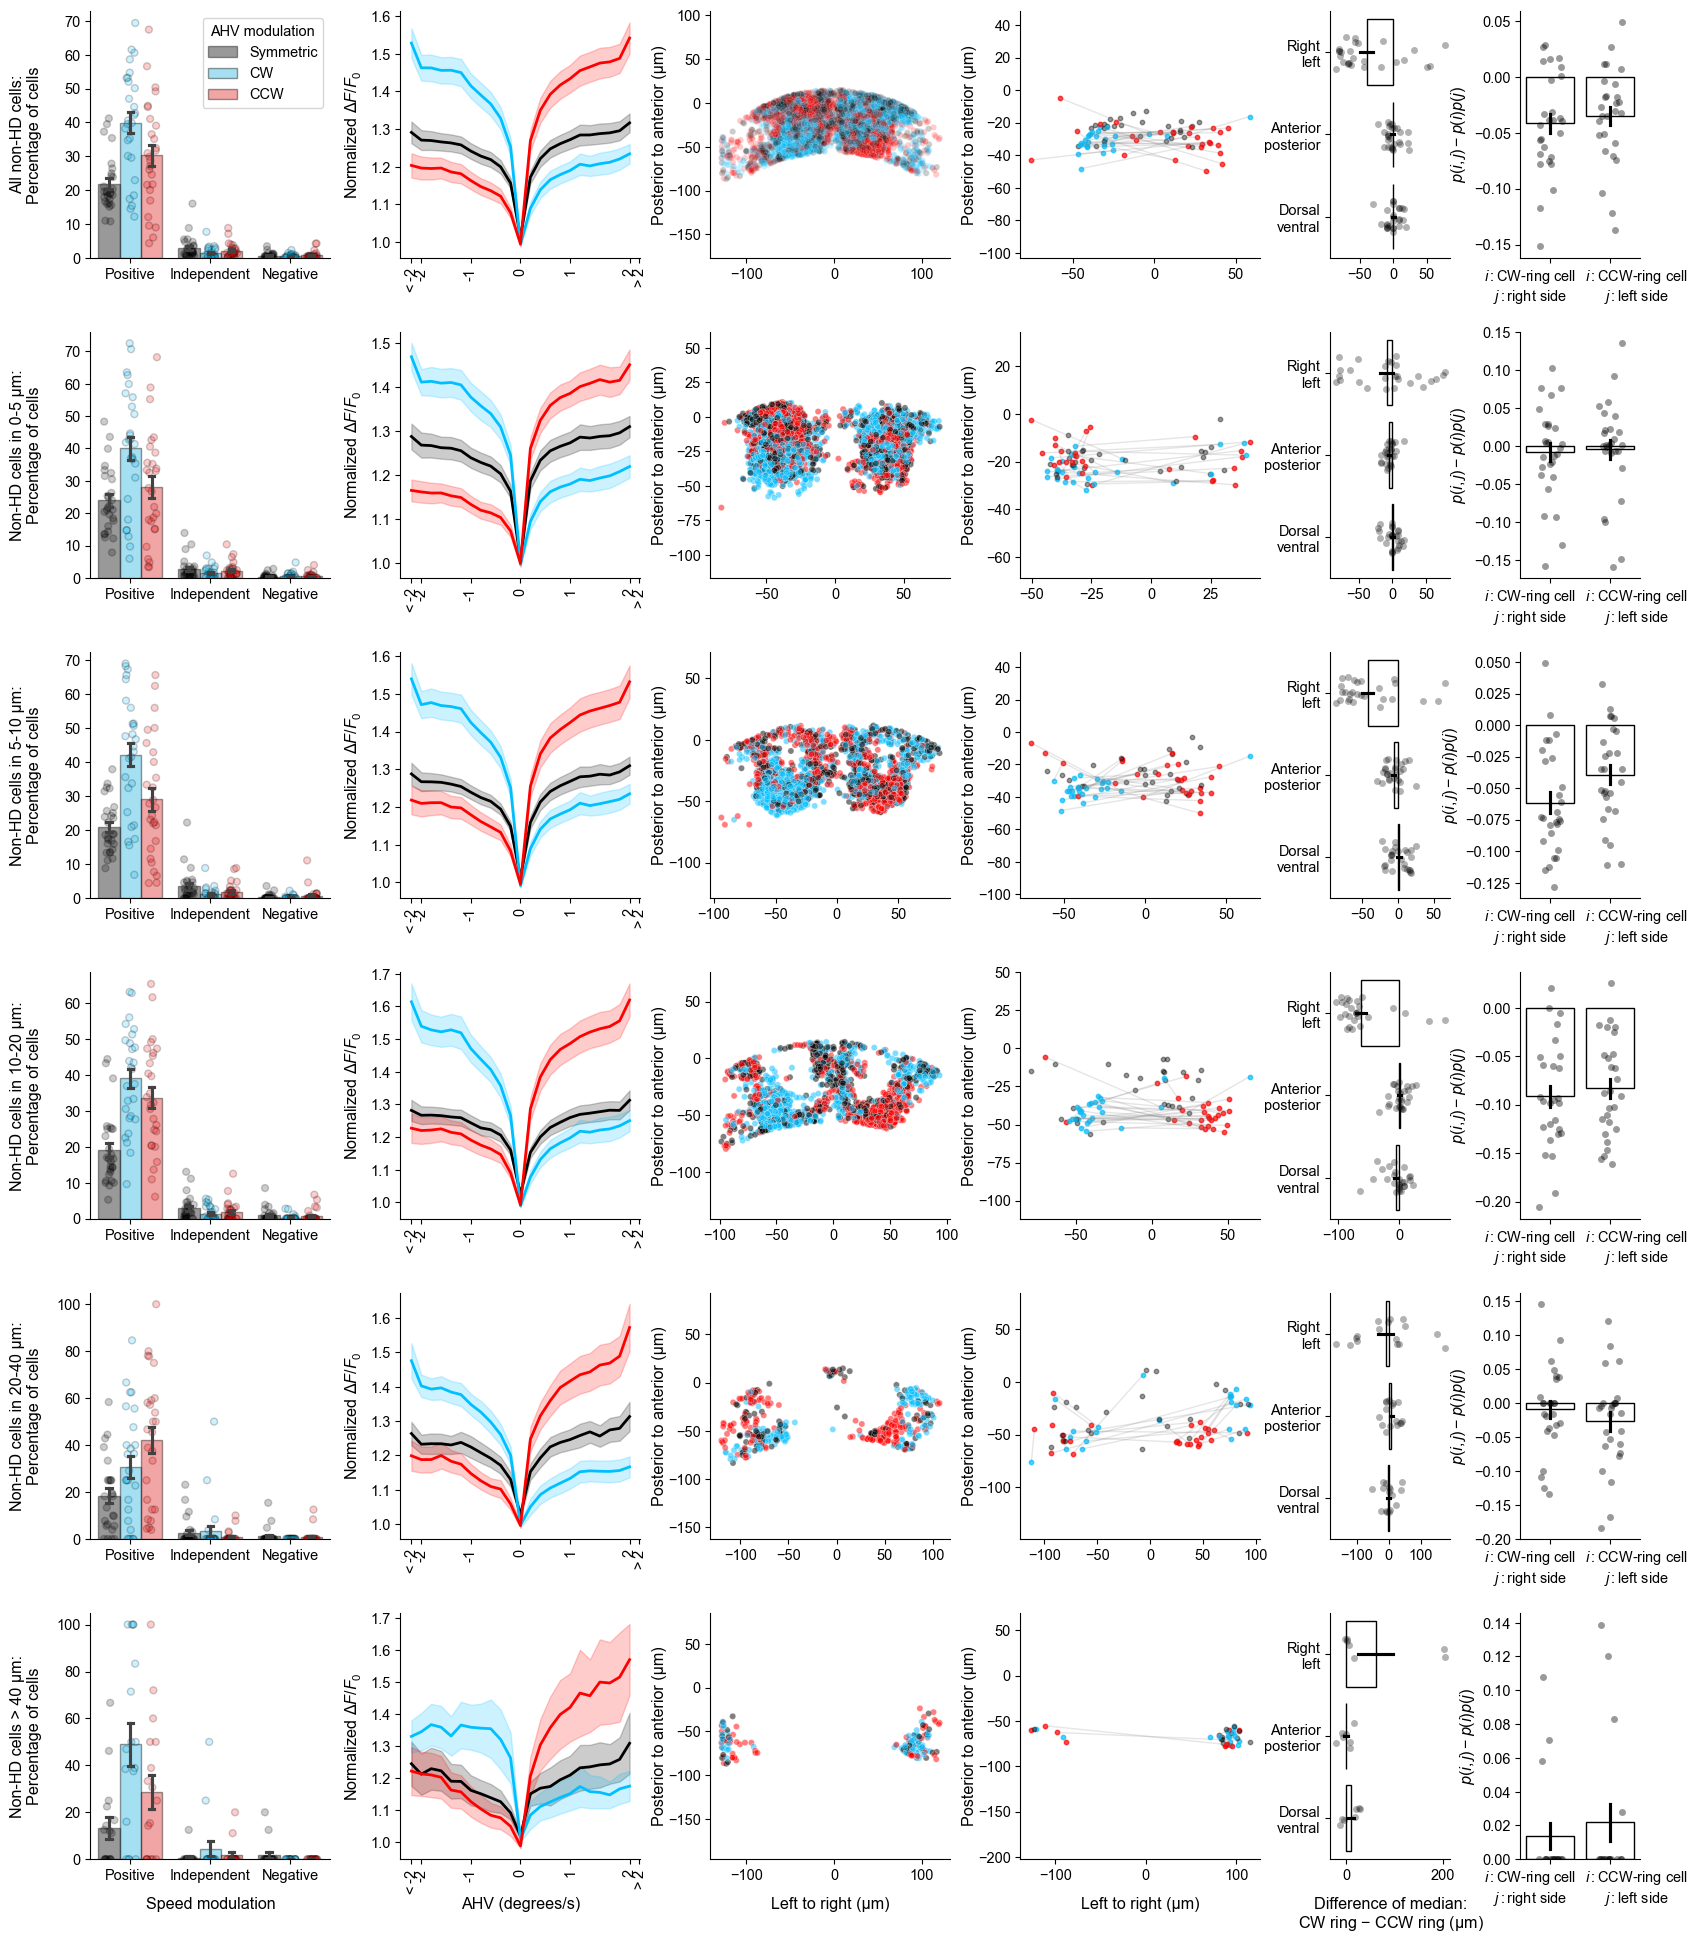

In [ ]:
# Determine angVel_bin_edge
data_noHD_vel = pd.read_pickle(FISH_RESULT_PATH / "data_ruben_noHD_vel.pkl")
vlimit = np.mean(np.abs(np.quantile(data_noHD_vel.angVel, [1/(NBINS+2), 1-1/(NBINS+2)])))
angVel_bin_edge = np.linspace(-vlimit, vlimit, NBINS+1)
del data_noHD_vel

# Titles
dist_labels = ['All non-HD cells:\nPercentage of cells'] + \
    [f'Non-HD cells in {k[0]}-{k[1]} µm:\nPercentage of cells' for k in THRESHOLDS[1:-1]] + \
    [f'Non-HD cells > {THRESHOLDS[-1][0]} µm:\nPercentage of cells']

# Create figure
ncol = 6
nrow = 6 # test
fig, axes = plt.subplots(nrow, ncol, figsize=(4*(ncol-1), nrow*4), width_ratios=[1,1,1,1,0.5,0.5])
plt.subplots_adjust(hspace=0.3, wspace=0.35)

for i in range(nrow):
    athreshold = THRESHOLDS[i]
    
    # Select cells based on distance
    stat_noHD_sel = stat_noHD_ahb.loc[(stat_noHD_ahb['dist2HD'] <= athreshold[1]) & (stat_noHD_ahb['dist2HD'] >= athreshold[0])]
    print('\n', athreshold)
    
    # 1. Speed modulation
    ax = axes[i, 0]
    
    stat_noHD_ahb_prop = cal_prop_each_cel_type(stat_noHD_sel)
    im = plot_prop_each_cel_type(stat_noHD_ahb_prop, ax)
    
    ## Formatting
    ax.set_ylabel(dist_labels[i])
    ax.yaxis.set_label_coords(-0.2, 0.5)
    
    xlabel_only_at_bottom(ax, i, nrow, 'Speed modulation')
    legend_only_at_top_and_with_title(ax, i, 'AHV modulation')
    
    # 2. Activity on AHV
    ax = axes[i, 1]
    iflegend = False
    data_sum = pd.read_pickle(FISH_RESULT_PATH / f"data_ruben_noHD_ahb_acv_on_AHV_thres{i}.pkl")
    im = plot_acv_on_AHV(data_sum, NBINS, ax, iflegend, angVel_bin_edge)
    
    ax.yaxis.set_label_coords(-0.15, 0.5)
    xlabel_only_at_bottom(ax, i, nrow, 'AHV (degrees/s)')
    
    # 3. Position of cells
    ax = axes[i, 2]
    alpha = 0.2 if i == 0 else 0.5
    im = plot_cell_location(ax, stat_noHD_sel, iflegend=False, equal_adjust='datalim', alpha=alpha)
    
    xlabel_only_at_bottom(ax, i, nrow, 'Left to right (µm)')
    ax.yaxis.set_label_coords(-0.18, 0.5)
    
    # 4. Median location of each ring
    ax = axes[i, 3]
    im = plot_median_loc(stat_noHD_sel, ax)
    
    xlabel_only_at_bottom(ax, i, nrow, 'Left to right (µm)')
    ax.yaxis.set_label_coords(-0.18, 0.5)
    
    # 5. median location t test
    ax = axes[i, 4]
    im = plot_median_loc_ttest(stat_noHD_sel, ax)
    
    xlabel_only_at_bottom(ax, i, nrow, 'Difference of median:\nCW ring $-$ CCW ring (μm)')
    
    # 6. pij-pipj
    ax = axes[i, 5]
    joint_prob_df = calculate_pij_minuspipj(stat_noHD_sel)
    plot_pij_minuspipj(joint_prob_df, ax)

fig.savefig(FIGURE_PATH / 'sup2.png', dpi=600, bbox_inches='tight')
plt.show()